In [1]:
import tensorflow as tf 
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models, optimizers, initializers, regularizers
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ML/dataset.csv')

In [3]:
df = df[pd.to_numeric(df['f1'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['f4'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['f5'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['f6'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['f7'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['target'], errors='coerce').notnull()]
df_numeric = df.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()
scaler = StandardScaler()
df_numeric[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']] = scaler.fit_transform(df_numeric[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']])

<Axes: >

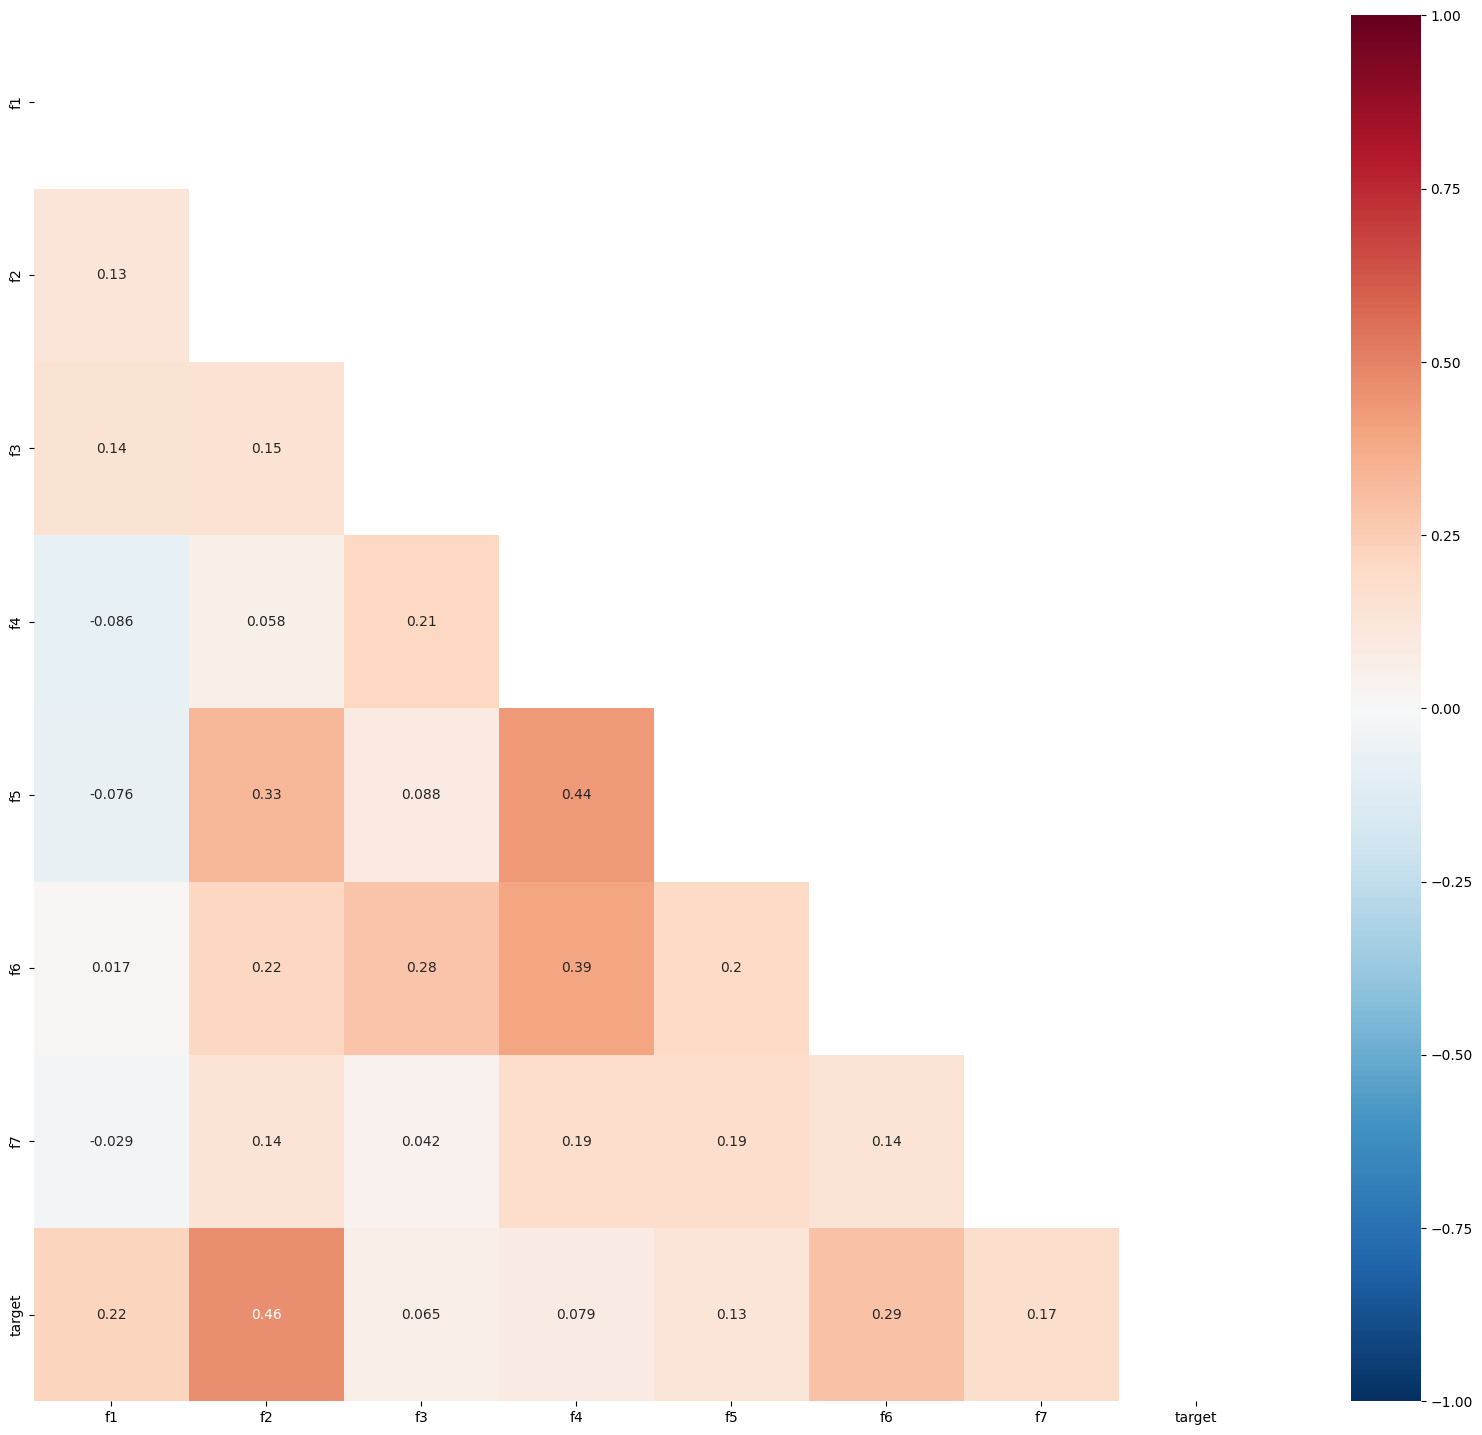

In [41]:
plt.figure(figsize=(20,18))
sns.heatmap(df_numeric.corr(), mask = np.triu(np.ones_like(df_numeric.corr(), dtype=bool)), vmin = -1.0, vmax = 1.0, 
          annot=True, cmap = 'RdBu_r')

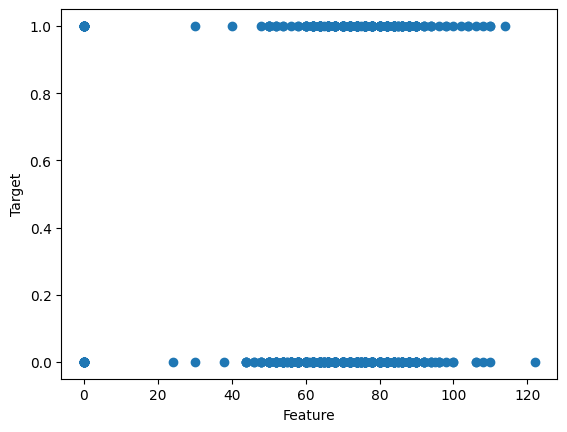

In [42]:
import matplotlib.pyplot as plt
plt.scatter(df['f3'], df['target'])
plt.xlabel('Feature')
plt.ylabel('Target')
plt.show()

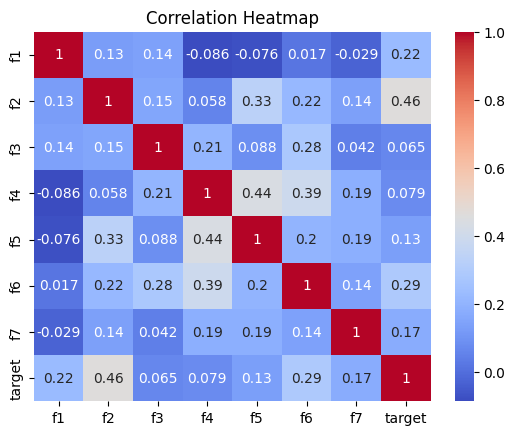

In [43]:
import seaborn as sns
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [4]:
X = df_numeric.drop('target', axis=1)
X = X[['f1','f2','f3', 'f4', 'f5', 'f6', 'f7']].astype(np.float32)
y = df_numeric['target'].astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [50]:
# , train
class NeuralNetwork:
    def __init__(self,model,var):
        self.model  = model
        self.opt_input = var
        if self.opt_input == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
            print("Optimizer is SGD")
        elif self.opt_input == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            print("Optimizer is Adam")
        elif self.opt_input == 'rmsprop':
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
            print("Optimizer is rmsprop")
        elif self.opt_input == 'Adamax':
            self.optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
            print("Optimizer is Adamax")

        self.lossFunction = tf.keras.losses.BinaryCrossentropy()
        self.trainingL = tf.keras.metrics.Mean(name='trainingL')
        self.trainingAcc = tf.keras.metrics.BinaryAccuracy(name='trainingAcc')
        # self.valL = tf.keras.metrics.Mean(name='valL')
        self.testingAcc = tf.keras.metrics.BinaryAccuracy(name='testingAcc')

    def step_decay(self,epoch):
        initLr = 0.1
        decay = 0.1
        lr = initLr * (decay ** (epoch // 5))
        return lr

    def train(self, X_train, train_labels, val_data, val_labels, epochs, batch_size,step_decay_flag = False,early_stopping = False,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = []):
      print("The Step Decay Flag Was set to ",step_decay_flag)
      early_stop_patience = 5
      maxLoss = np.inf
      maxLossEpoch = 0

      for epoch in range(epochs):
        if step_decay_flag:
          lr = self.step_decay(epoch)
          self.optimizer.learning_rate = lr
        for step in range(X_train.shape[0] // batch_size):
          X_batch = X_train.iloc[step*batch_size:(step+1)*batch_size].values.astype(np.float32)
          y_batch = y_train.iloc[step*batch_size:(step+1)*batch_size].values.reshape((-1,1))
          with tf.GradientTape() as tape:
                y_pred = self.model(X_batch, training=True)
                loss = self.lossFunction(y_batch, y_pred)
          grads = tape.gradient(loss, self.model.trainable_weights)
          self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
          self.trainingL.update_state(loss)
          self.trainingAcc.update_state(y_batch, y_pred)

        trainingLossArr.append(self.trainingL.result())
        trainingAccArr.append(self.trainingAcc.result())

        test_y_pred = self.model(X_val.iloc[::].values.astype(np.float32))
        test_loss = self.lossFunction(y_val.iloc[::].values.reshape((-1,1)), test_y_pred)
        testingLossArr.append(test_loss)
        self.testingAcc.update_state(y_val.values.reshape((-1,1)), test_y_pred)
        testingAccArr.append(self.testingAcc.result())
        print(f"Epoch {epoch + 1}, "
              f"Train Loss: {self.trainingL.result():.4f}, "
              f"Train Accuracy: {self.trainingAcc.result():.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {self.testingAcc.result():.4f}")
        
        if early_stopping:
            print("Early Stopping Enabled")
            if test_loss < maxLoss:
                  maxLoss = test_loss
                  maxLossEpoch = epoch
              
            if epoch - maxLossEpoch >= early_stop_patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break
      
      plt.plot(trainingLossArr, label='Training Loss')
      plt.plot(testingLossArr, label='Testing Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
      plt.plot(trainingAccArr, label='Training Accuracy')
      plt.plot(testingAccArr, label='Testing Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()
      return trainingLossArr,trainingAccArr,testingLossArr,testingAccArr
      

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6701, Train Accuracy: 0.6562, Test Loss: 0.6648, Test Accuracy: 0.6776
Epoch 2, Train Loss: 0.6594, Train Accuracy: 0.6604, Test Loss: 0.6464, Test Accuracy: 0.6809
Epoch 3, Train Loss: 0.6497, Train Accuracy: 0.6612, Test Loss: 0.6308, Test Accuracy: 0.6842
Epoch 4, Train Loss: 0.6410, Train Accuracy: 0.6686, Test Loss: 0.6176, Test Accuracy: 0.6842
Epoch 5, Train Loss: 0.6330, Train Accuracy: 0.6757, Test Loss: 0.6062, Test Accuracy: 0.6868
Epoch 6, Train Loss: 0.6258, Train Accuracy: 0.6839, Test Loss: 0.5963, Test Accuracy: 0.6886
Epoch 7, Train Loss: 0.6191, Train Accuracy: 0.6913, Test Loss: 0.5878, Test Accuracy: 0.6927
Epoch 8, Train Loss: 0.6130, Train Accuracy: 0.6988, Test Loss: 0.5803, Test Accuracy: 0.6965
Epoch 9, Train Loss: 0.6073, Train Accuracy: 0.7052, Test Loss: 0.5737, Test Accuracy: 0.7003
Epoch 10, Train Loss: 0.6020, Train Accuracy: 0.7105, Test Loss: 0.5678, Test Accuracy: 0.7033
Epoc

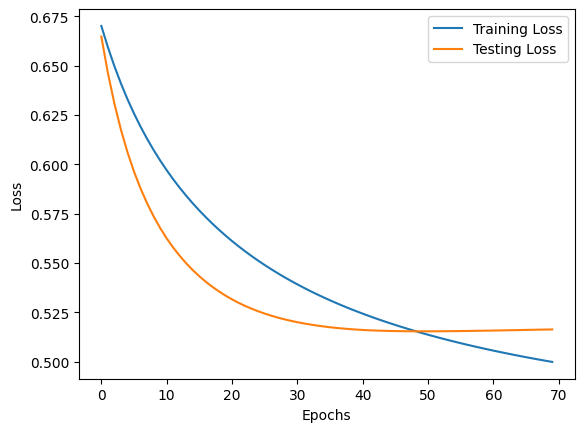

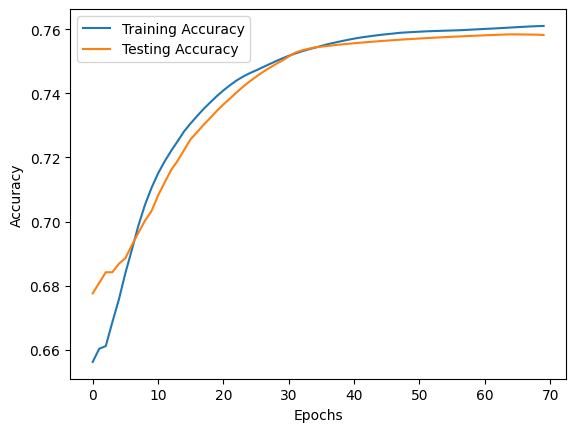

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs = 70
batch_size = 32
first_nn = NeuralNetwork(model,'sgd')
first_train = first_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model.save_weights('/content/drive/MyDrive/ML_2/final_part_1_model_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6914, Train Accuracy: 0.5378, Test Loss: 0.6876, Test Accuracy: 0.5197
Epoch 2, Train Loss: 0.6800, Train Accuracy: 0.5748, Test Loss: 0.6661, Test Accuracy: 0.5724
Epoch 3, Train Loss: 0.6676, Train Accuracy: 0.6118, Test Loss: 0.6481, Test Accuracy: 0.5965
Epoch 4, Train Loss: 0.6585, Train Accuracy: 0.6390, Test Loss: 0.6332, Test Accuracy: 0.6201
Epoch 5, Train Loss: 0.6488, Train Accuracy: 0.6602, Test Loss: 0.6210, Test Accuracy: 0.6368
Epoch 6, Train Loss: 0.6414, Train Accuracy: 0.6738, Test Loss: 0.6103, Test Accuracy: 0.6513
Epoch 7, Train Loss: 0.6346, Train Accuracy: 0.6849, Test Loss: 0.6007, Test Accuracy: 0.6617
Epoch 8, Train Loss: 0.6284, Train Accuracy: 0.6926, Test Loss: 0.5924, Test Accuracy: 0.6702
Epoch 9, Train Loss: 0.6224, Train Accuracy: 0.6994, Test Loss: 0.5851, Test Accuracy: 0.6762
Epoch 10, Train Loss: 0.6172, Train Accuracy: 0.7039, Test Loss: 0.5788, Test Accuracy: 0.6803
Epoc

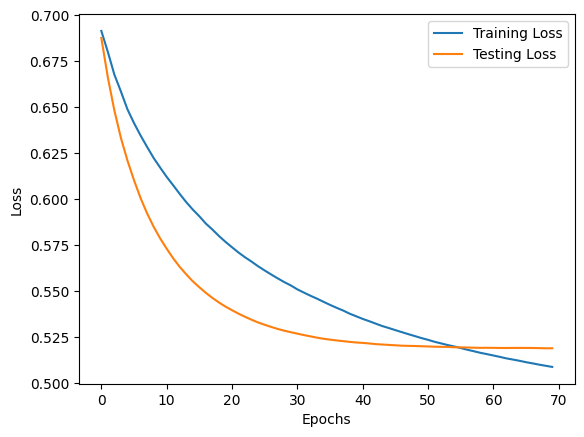

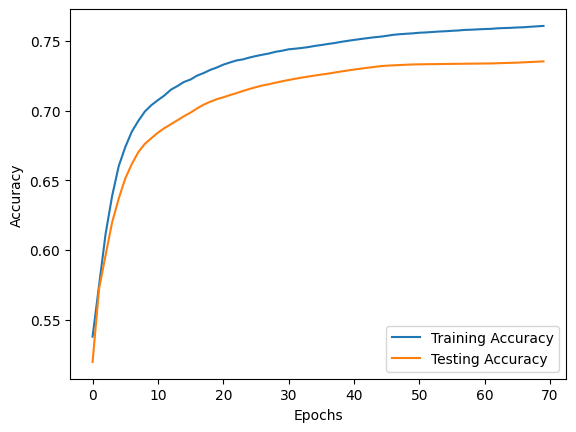

In [16]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
second_nn = NeuralNetwork(model_2,'sgd')
second_train = second_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_2.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_2_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6964, Train Accuracy: 0.6053, Test Loss: 0.6577, Test Accuracy: 0.6908
Epoch 2, Train Loss: 0.6783, Train Accuracy: 0.6258, Test Loss: 0.6425, Test Accuracy: 0.6941
Epoch 3, Train Loss: 0.6664, Train Accuracy: 0.6327, Test Loss: 0.6298, Test Accuracy: 0.6996
Epoch 4, Train Loss: 0.6558, Train Accuracy: 0.6476, Test Loss: 0.6180, Test Accuracy: 0.7023
Epoch 5, Train Loss: 0.6500, Train Accuracy: 0.6562, Test Loss: 0.6081, Test Accuracy: 0.7053
Epoch 6, Train Loss: 0.6409, Train Accuracy: 0.6664, Test Loss: 0.5995, Test Accuracy: 0.7127
Epoch 7, Train Loss: 0.6325, Train Accuracy: 0.6711, Test Loss: 0.5920, Test Accuracy: 0.7180
Epoch 8, Train Loss: 0.6244, Train Accuracy: 0.6801, Test Loss: 0.5849, Test Accuracy: 0.7237
Epoch 9, Train Loss: 0.6176, Train Accuracy: 0.6866, Test Loss: 0.5792, Test Accuracy: 0.7281
Epoch 10, Train Loss: 0.6125, Train Accuracy: 0.6906, Test Loss: 0.5739, Test Accuracy: 0.7316
Epoc

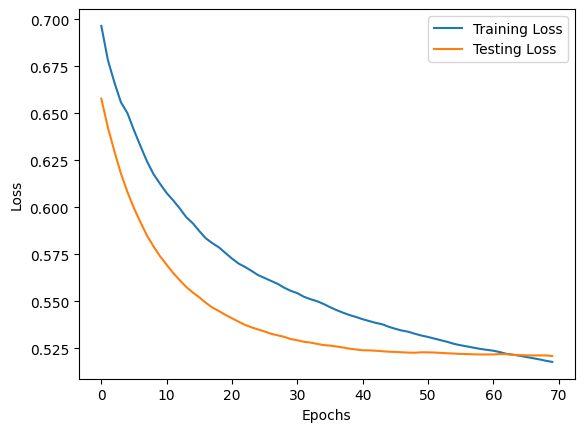

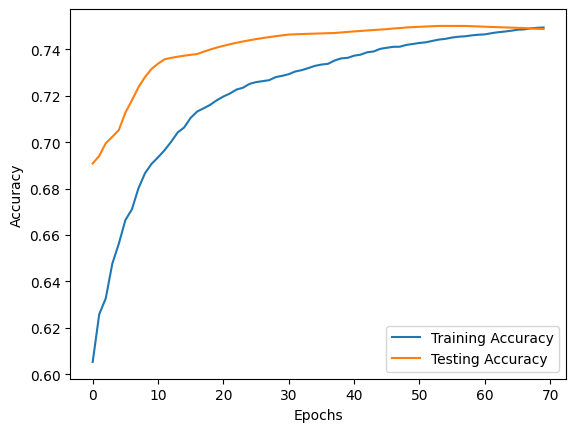

In [17]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
third_nn = NeuralNetwork(model_3,'sgd')
third_train = third_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_3.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_3_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7916, Train Accuracy: 0.4951, Test Loss: 0.7316, Test Accuracy: 0.5197
Epoch 2, Train Loss: 0.7640, Train Accuracy: 0.5115, Test Loss: 0.6982, Test Accuracy: 0.5395
Epoch 3, Train Loss: 0.7523, Train Accuracy: 0.5197, Test Loss: 0.6728, Test Accuracy: 0.5746
Epoch 4, Train Loss: 0.7377, Train Accuracy: 0.5296, Test Loss: 0.6504, Test Accuracy: 0.5905
Epoch 5, Train Loss: 0.7263, Train Accuracy: 0.5447, Test Loss: 0.6330, Test Accuracy: 0.6079
Epoch 6, Train Loss: 0.7152, Train Accuracy: 0.5620, Test Loss: 0.6193, Test Accuracy: 0.6272
Epoch 7, Train Loss: 0.7072, Train Accuracy: 0.5698, Test Loss: 0.6075, Test Accuracy: 0.6391
Epoch 8, Train Loss: 0.6968, Train Accuracy: 0.5796, Test Loss: 0.5968, Test Accuracy: 0.6488
Epoch 9, Train Loss: 0.6889, Train Accuracy: 0.5883, Test Loss: 0.5887, Test Accuracy: 0.6572
Epoch 10, Train Loss: 0.6830, Train Accuracy: 0.5972, Test Loss: 0.5821, Test Accuracy: 0.6638
Epoc

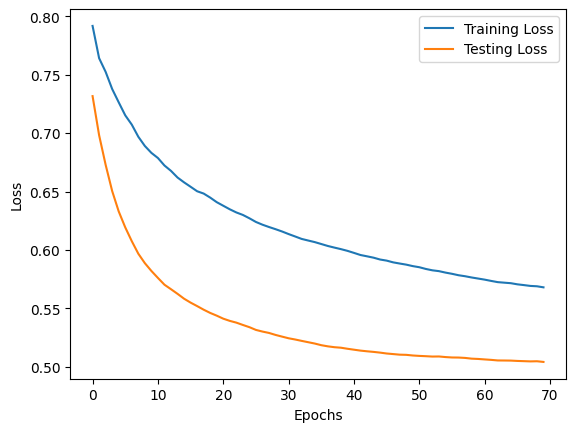

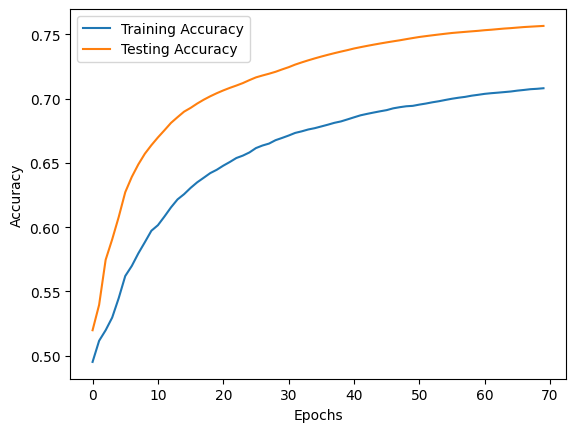

In [19]:
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dropout(0.8),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.6),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
four_nn = NeuralNetwork(model_4,'sgd')
four_train = four_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_4.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_4_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7773, Train Accuracy: 0.5905, Test Loss: 0.6550, Test Accuracy: 0.7039
Epoch 2, Train Loss: 0.7590, Train Accuracy: 0.5979, Test Loss: 0.6384, Test Accuracy: 0.7072
Epoch 3, Train Loss: 0.7471, Train Accuracy: 0.5987, Test Loss: 0.6239, Test Accuracy: 0.7083
Epoch 4, Train Loss: 0.7305, Train Accuracy: 0.6114, Test Loss: 0.6135, Test Accuracy: 0.7105
Epoch 5, Train Loss: 0.7216, Train Accuracy: 0.6115, Test Loss: 0.6037, Test Accuracy: 0.7118
Epoch 6, Train Loss: 0.7162, Train Accuracy: 0.6129, Test Loss: 0.5955, Test Accuracy: 0.7138
Epoch 7, Train Loss: 0.7046, Train Accuracy: 0.6208, Test Loss: 0.5884, Test Accuracy: 0.7162
Epoch 8, Train Loss: 0.6977, Train Accuracy: 0.6244, Test Loss: 0.5827, Test Accuracy: 0.7188
Epoch 9, Train Loss: 0.6913, Train Accuracy: 0.6274, Test Loss: 0.5777, Test Accuracy: 0.7208
Epoch 10, Train Loss: 0.6855, Train Accuracy: 0.6298, Test Loss: 0.5730, Test Accuracy: 0.7237
Epoc

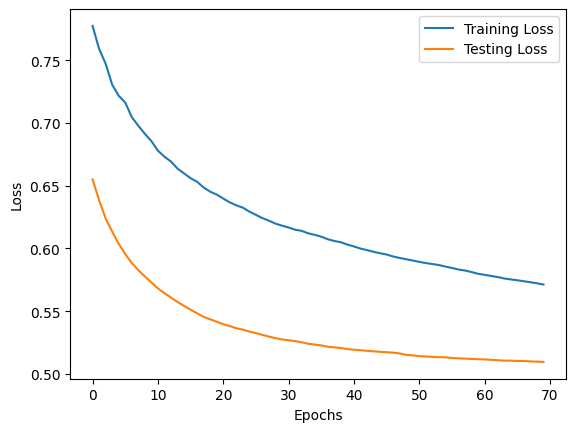

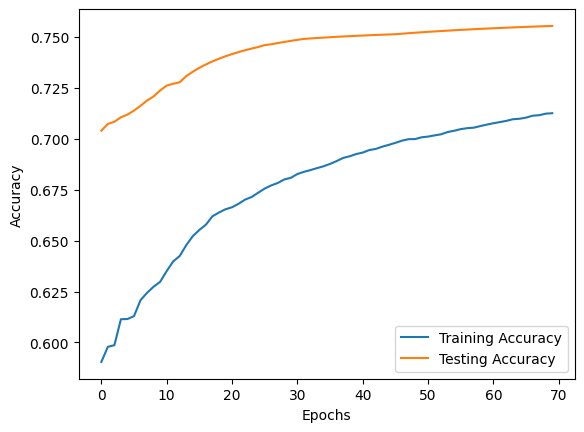

In [22]:
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
five_nn = NeuralNetwork(model_5,'sgd')
five_train = five_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_5.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_5_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6872, Train Accuracy: 0.6102, Test Loss: 0.6783, Test Accuracy: 0.6711
Epoch 2, Train Loss: 0.6788, Train Accuracy: 0.6447, Test Loss: 0.6630, Test Accuracy: 0.6743
Epoch 3, Train Loss: 0.6706, Train Accuracy: 0.6661, Test Loss: 0.6488, Test Accuracy: 0.6711
Epoch 4, Train Loss: 0.6630, Train Accuracy: 0.6764, Test Loss: 0.6351, Test Accuracy: 0.6743
Epoch 5, Train Loss: 0.6559, Train Accuracy: 0.6822, Test Loss: 0.6230, Test Accuracy: 0.6789
Epoch 6, Train Loss: 0.6492, Train Accuracy: 0.6850, Test Loss: 0.6120, Test Accuracy: 0.6831
Epoch 7, Train Loss: 0.6434, Train Accuracy: 0.6884, Test Loss: 0.6021, Test Accuracy: 0.6852
Epoch 8, Train Loss: 0.6378, Train Accuracy: 0.6926, Test Loss: 0.5931, Test Accuracy: 0.6891
Epoch 9, Train Loss: 0.6324, Train Accuracy: 0.6952, Test Loss: 0.5854, Test Accuracy: 0.6944
Epoch 10, Train Loss: 0.6275, Train Accuracy: 0.6985, Test Loss: 0.5779, Test Accuracy: 0.7000
Epoc

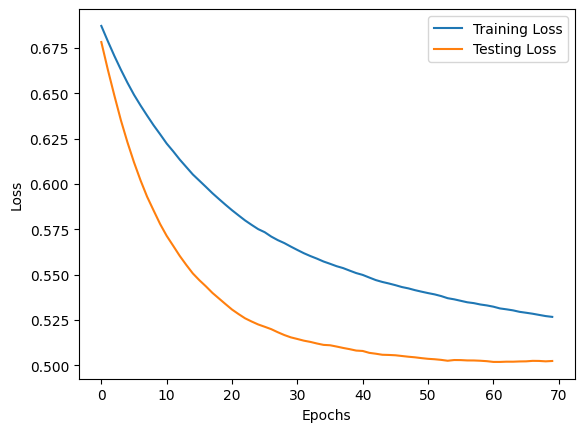

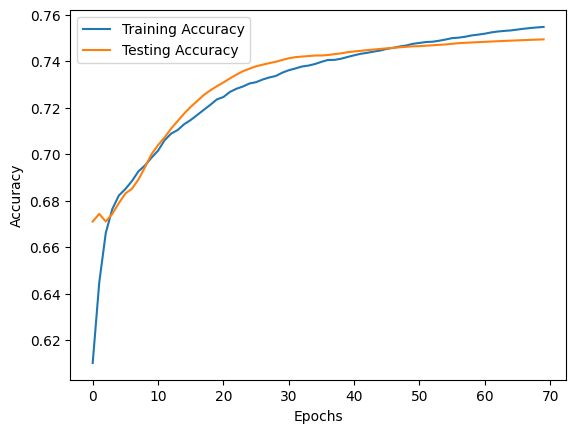

In [44]:
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.RandomNormal(stddev=0.01)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
six_nn = NeuralNetwork(model_6,'sgd')
six_train = six_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_6.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_6_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7205, Train Accuracy: 0.5493, Test Loss: 0.6526, Test Accuracy: 0.6711
Epoch 2, Train Loss: 0.7097, Train Accuracy: 0.5806, Test Loss: 0.6390, Test Accuracy: 0.7039
Epoch 3, Train Loss: 0.7029, Train Accuracy: 0.5789, Test Loss: 0.6264, Test Accuracy: 0.7193
Epoch 4, Train Loss: 0.6970, Train Accuracy: 0.5933, Test Loss: 0.6150, Test Accuracy: 0.7319
Epoch 5, Train Loss: 0.6853, Train Accuracy: 0.6046, Test Loss: 0.6054, Test Accuracy: 0.7395
Epoch 6, Train Loss: 0.6767, Train Accuracy: 0.6149, Test Loss: 0.5972, Test Accuracy: 0.7445
Epoch 7, Train Loss: 0.6724, Train Accuracy: 0.6177, Test Loss: 0.5905, Test Accuracy: 0.7481
Epoch 8, Train Loss: 0.6675, Train Accuracy: 0.6273, Test Loss: 0.5839, Test Accuracy: 0.7525
Epoch 9, Train Loss: 0.6640, Train Accuracy: 0.6314, Test Loss: 0.5787, Test Accuracy: 0.7551
Epoch 10, Train Loss: 0.6581, Train Accuracy: 0.6400, Test Loss: 0.5730, Test Accuracy: 0.7572
Epoc

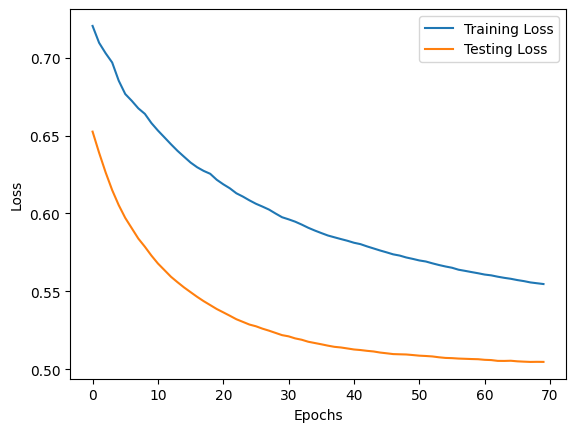

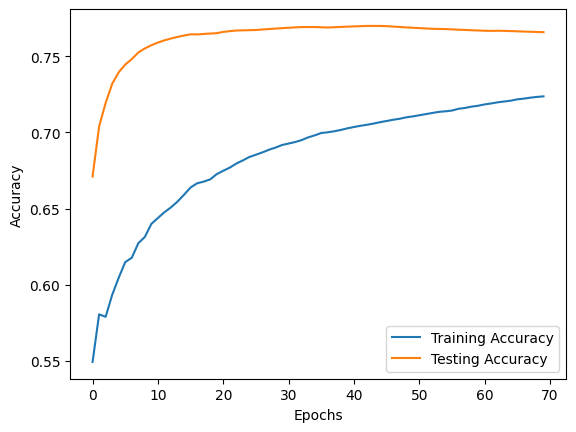

In [25]:
model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
seven_nn = NeuralNetwork(model_7,'sgd')
seven_train = seven_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_7.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_7_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7402, Train Accuracy: 0.5164, Test Loss: 0.6558, Test Accuracy: 0.6118
Epoch 2, Train Loss: 0.7146, Train Accuracy: 0.5411, Test Loss: 0.6234, Test Accuracy: 0.6579
Epoch 3, Train Loss: 0.6922, Train Accuracy: 0.5740, Test Loss: 0.6004, Test Accuracy: 0.6798
Epoch 4, Train Loss: 0.6750, Train Accuracy: 0.5933, Test Loss: 0.5827, Test Accuracy: 0.7023
Epoch 5, Train Loss: 0.6615, Train Accuracy: 0.6105, Test Loss: 0.5689, Test Accuracy: 0.7145
Epoch 6, Train Loss: 0.6498, Train Accuracy: 0.6277, Test Loss: 0.5585, Test Accuracy: 0.7248
Epoch 7, Train Loss: 0.6397, Train Accuracy: 0.6382, Test Loss: 0.5484, Test Accuracy: 0.7312
Epoch 8, Train Loss: 0.6335, Train Accuracy: 0.6439, Test Loss: 0.5403, Test Accuracy: 0.7360
Epoch 9, Train Loss: 0.6254, Train Accuracy: 0.6522, Test Loss: 0.5338, Test Accuracy: 0.7398
Epoch 10, Train Loss: 0.6165, Train Accuracy: 0.6607, Test Loss: 0.5292, Test Accuracy: 0.7434
Epoc

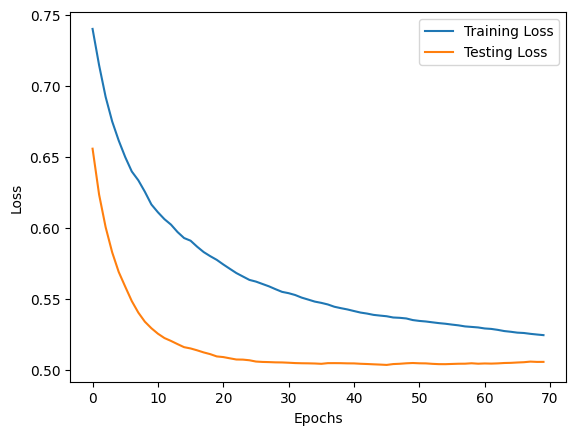

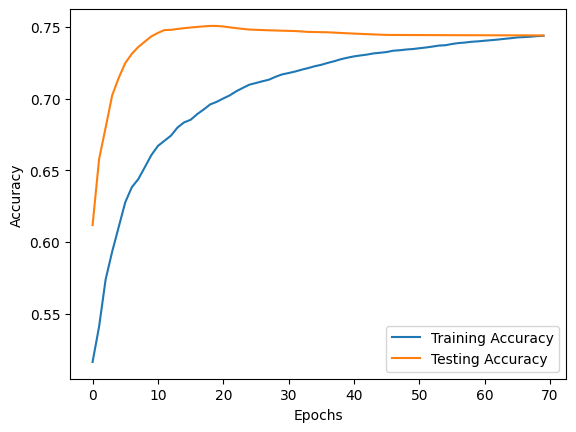

In [9]:
model_tan = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
tan_nn = NeuralNetwork(model_tan,'sgd')
tan_train = tan_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_tan.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_tan_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7295, Train Accuracy: 0.5296, Test Loss: 0.7051, Test Accuracy: 0.4737
Epoch 2, Train Loss: 0.7262, Train Accuracy: 0.5263, Test Loss: 0.6765, Test Accuracy: 0.5658
Epoch 3, Train Loss: 0.7152, Train Accuracy: 0.5411, Test Loss: 0.6547, Test Accuracy: 0.6096
Epoch 4, Train Loss: 0.7023, Train Accuracy: 0.5629, Test Loss: 0.6368, Test Accuracy: 0.6382
Epoch 5, Train Loss: 0.6932, Train Accuracy: 0.5760, Test Loss: 0.6211, Test Accuracy: 0.6539
Epoch 6, Train Loss: 0.6867, Train Accuracy: 0.5850, Test Loss: 0.6067, Test Accuracy: 0.6678
Epoch 7, Train Loss: 0.6794, Train Accuracy: 0.5982, Test Loss: 0.5954, Test Accuracy: 0.6786
Epoch 8, Train Loss: 0.6725, Train Accuracy: 0.6100, Test Loss: 0.5859, Test Accuracy: 0.6867
Epoch 9, Train Loss: 0.6625, Train Accuracy: 0.6208, Test Loss: 0.5779, Test Accuracy: 0.6937
Epoch 10, Train Loss: 0.6575, Train Accuracy: 0.6286, Test Loss: 0.5707, Test Accuracy: 0.6993
Epoc

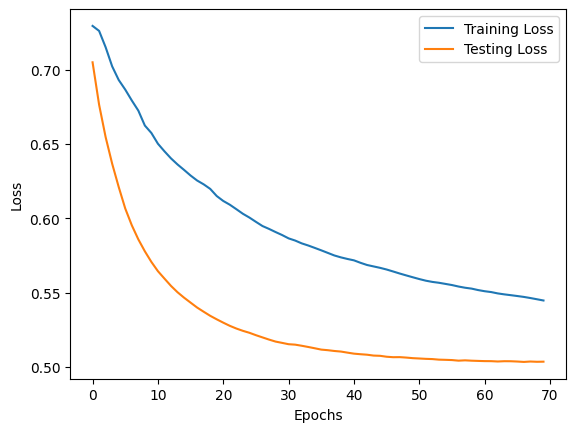

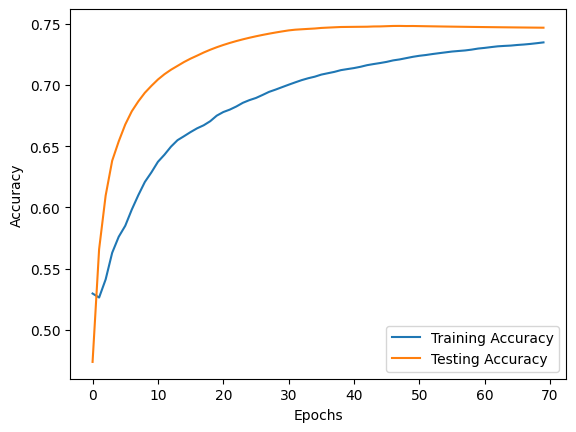

In [10]:
model_8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='LeakyReLU', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
eight_nn = NeuralNetwork(model_8,'sgd')
eight_train = eight_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_8.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_8_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7805, Train Accuracy: 0.5181, Test Loss: 0.6890, Test Accuracy: 0.6184
Epoch 2, Train Loss: 0.7441, Train Accuracy: 0.5576, Test Loss: 0.6538, Test Accuracy: 0.6414
Epoch 3, Train Loss: 0.7158, Train Accuracy: 0.5850, Test Loss: 0.6264, Test Accuracy: 0.6579
Epoch 4, Train Loss: 0.7004, Train Accuracy: 0.6044, Test Loss: 0.6060, Test Accuracy: 0.6760
Epoch 5, Train Loss: 0.6816, Train Accuracy: 0.6145, Test Loss: 0.5896, Test Accuracy: 0.6882
Epoch 6, Train Loss: 0.6670, Train Accuracy: 0.6220, Test Loss: 0.5760, Test Accuracy: 0.6974
Epoch 7, Train Loss: 0.6584, Train Accuracy: 0.6306, Test Loss: 0.5645, Test Accuracy: 0.7049
Epoch 8, Train Loss: 0.6513, Train Accuracy: 0.6384, Test Loss: 0.5563, Test Accuracy: 0.7097
Epoch 9, Train Loss: 0.6438, Train Accuracy: 0.6488, Test Loss: 0.5487, Test Accuracy: 0.7142
Epoch 10, Train Loss: 0.6381, Train Accuracy: 0.6553, Test Loss: 0.5422, Test Accuracy: 0.7184
Epoc

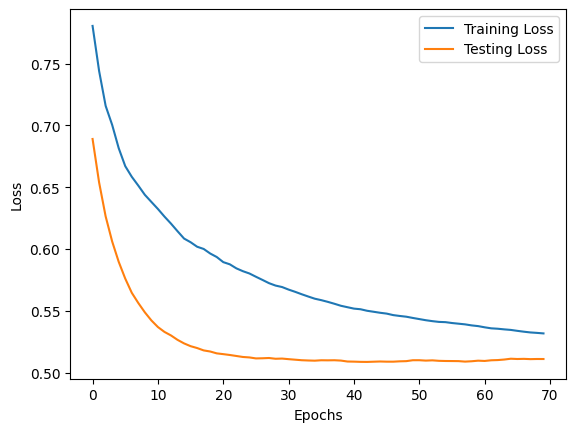

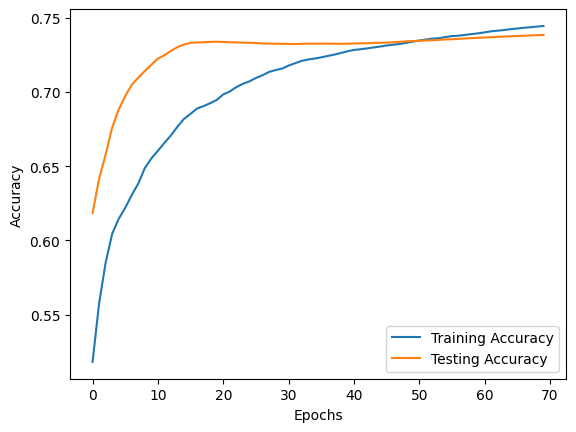

In [11]:
model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='linear', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
nine_nn = NeuralNetwork(model_9,'sgd')
nine_train = nine_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_9.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_9_weights.h5')

Optimizer is Adam
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6437, Train Accuracy: 0.6530, Test Loss: 0.5439, Test Accuracy: 0.7303
Epoch 2, Train Loss: 0.5919, Train Accuracy: 0.6998, Test Loss: 0.5243, Test Accuracy: 0.7270
Epoch 3, Train Loss: 0.5704, Train Accuracy: 0.7275, Test Loss: 0.5205, Test Accuracy: 0.7325
Epoch 4, Train Loss: 0.5558, Train Accuracy: 0.7323, Test Loss: 0.5175, Test Accuracy: 0.7352
Epoch 5, Train Loss: 0.5452, Train Accuracy: 0.7408, Test Loss: 0.5127, Test Accuracy: 0.7395
Epoch 6, Train Loss: 0.5406, Train Accuracy: 0.7445, Test Loss: 0.5103, Test Accuracy: 0.7412
Epoch 7, Train Loss: 0.5341, Train Accuracy: 0.7474, Test Loss: 0.5123, Test Accuracy: 0.7406
Epoch 8, Train Loss: 0.5305, Train Accuracy: 0.7486, Test Loss: 0.5134, Test Accuracy: 0.7434
Epoch 9, Train Loss: 0.5291, Train Accuracy: 0.7502, Test Loss: 0.5131, Test Accuracy: 0.7449
Epoch 10, Train Loss: 0.5250, Train Accuracy: 0.7518, Test Loss: 0.5156, Test Accuracy: 0.7454
Epo

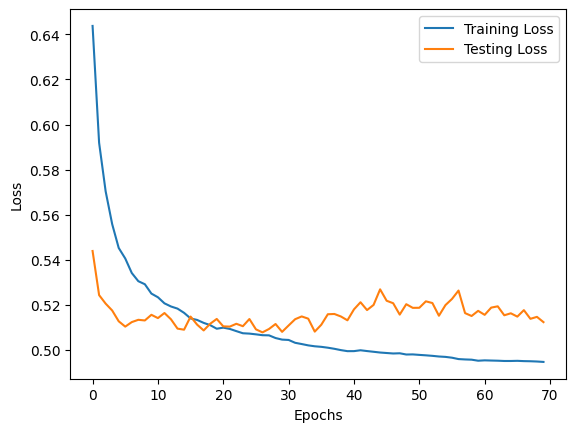

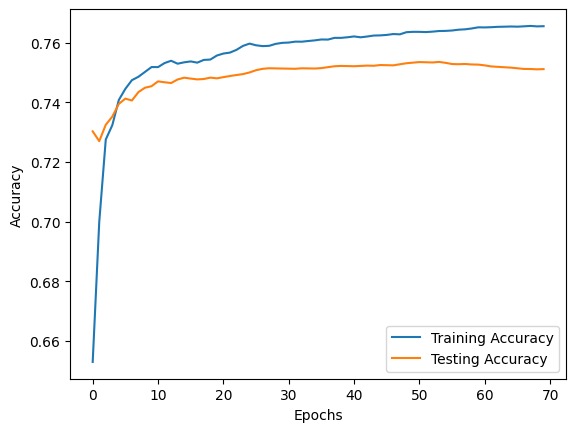

In [12]:
model_10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
ten_nn = NeuralNetwork(model_10,'adam')
ten_train = ten_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_10.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_10_weights.h5')

Optimizer is rmsprop
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6805, Train Accuracy: 0.6168, Test Loss: 0.6439, Test Accuracy: 0.6250
Epoch 2, Train Loss: 0.6765, Train Accuracy: 0.6102, Test Loss: 0.6218, Test Accuracy: 0.6382
Epoch 3, Train Loss: 0.6656, Train Accuracy: 0.6283, Test Loss: 0.6012, Test Accuracy: 0.6535
Epoch 4, Train Loss: 0.6604, Train Accuracy: 0.6390, Test Loss: 0.5849, Test Accuracy: 0.6628
Epoch 5, Train Loss: 0.6456, Train Accuracy: 0.6576, Test Loss: 0.5711, Test Accuracy: 0.6724
Epoch 6, Train Loss: 0.6331, Train Accuracy: 0.6637, Test Loss: 0.5599, Test Accuracy: 0.6798
Epoch 7, Train Loss: 0.6254, Train Accuracy: 0.6715, Test Loss: 0.5509, Test Accuracy: 0.6889
Epoch 8, Train Loss: 0.6179, Train Accuracy: 0.6789, Test Loss: 0.5432, Test Accuracy: 0.6965
Epoch 9, Train Loss: 0.6132, Train Accuracy: 0.6820, Test Loss: 0.5370, Test Accuracy: 0.7032
Epoch 10, Train Loss: 0.6049, Train Accuracy: 0.6900, Test Loss: 0.5308, Test Accuracy: 0.7092


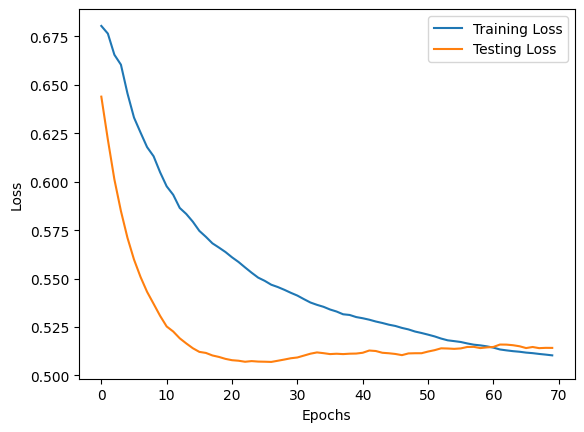

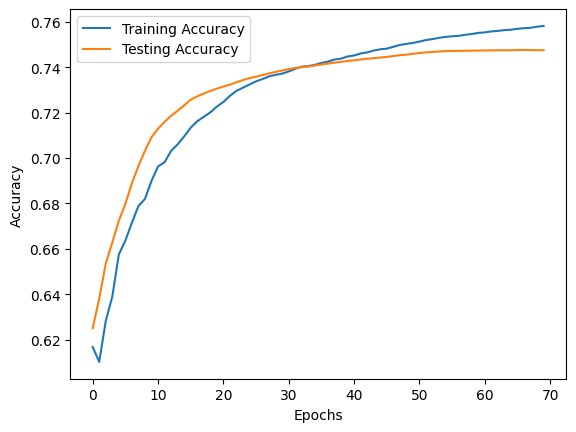

In [13]:
model_11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
eleven_nn = NeuralNetwork(model_11,'rmsprop')
eleven_train = eleven_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_11.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_11_weights.h5')

Optimizer is Adamax
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6838, Train Accuracy: 0.5872, Test Loss: 0.5631, Test Accuracy: 0.7566
Epoch 2, Train Loss: 0.6316, Train Accuracy: 0.6382, Test Loss: 0.5244, Test Accuracy: 0.7664
Epoch 3, Train Loss: 0.6099, Train Accuracy: 0.6700, Test Loss: 0.5110, Test Accuracy: 0.7675
Epoch 4, Train Loss: 0.5845, Train Accuracy: 0.6937, Test Loss: 0.5062, Test Accuracy: 0.7648
Epoch 5, Train Loss: 0.5743, Train Accuracy: 0.7049, Test Loss: 0.5055, Test Accuracy: 0.7671
Epoch 6, Train Loss: 0.5638, Train Accuracy: 0.7127, Test Loss: 0.5066, Test Accuracy: 0.7632
Epoch 7, Train Loss: 0.5540, Train Accuracy: 0.7232, Test Loss: 0.5074, Test Accuracy: 0.7622
Epoch 8, Train Loss: 0.5495, Train Accuracy: 0.7311, Test Loss: 0.5085, Test Accuracy: 0.7615
Epoch 9, Train Loss: 0.5460, Train Accuracy: 0.7356, Test Loss: 0.5097, Test Accuracy: 0.7610
Epoch 10, Train Loss: 0.5400, Train Accuracy: 0.7393, Test Loss: 0.5084, Test Accuracy: 0.7605
E

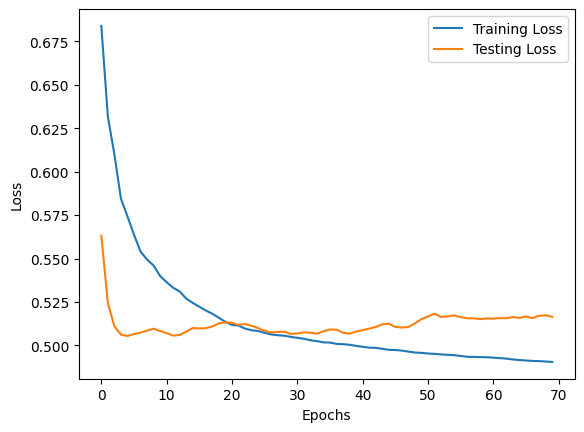

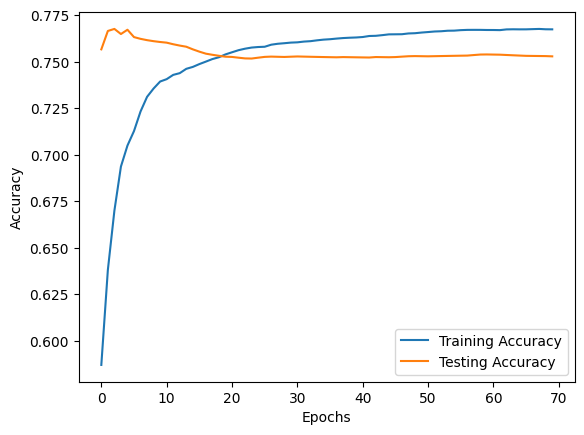

In [15]:
model_12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
tweleve_nn = NeuralNetwork(model_12,'Adamax')
tweleve_train = tweleve_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_12.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_12_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.6984, Train Accuracy: 0.5477, Test Loss: 0.6537, Test Accuracy: 0.6711
Epoch 2, Train Loss: 0.6980, Train Accuracy: 0.5625, Test Loss: 0.6409, Test Accuracy: 0.6908
Epoch 3, Train Loss: 0.6921, Train Accuracy: 0.5800, Test Loss: 0.6301, Test Accuracy: 0.6974
Epoch 4, Train Loss: 0.6836, Train Accuracy: 0.5946, Test Loss: 0.6212, Test Accuracy: 0.7056
Epoch 5, Train Loss: 0.6730, Train Accuracy: 0.6062, Test Loss: 0.6130, Test Accuracy: 0.7132
Epoch 6, Train Loss: 0.6649, Train Accuracy: 0.6192, Test Loss: 0.6050, Test Accuracy: 0.7204
Epoch 7, Train Loss: 0.6589, Train Accuracy: 0.6302, Test Loss: 0.5985, Test Accuracy: 0.7256
Epoch 8, Train Loss: 0.6549, Train Accuracy: 0.6349, Test Loss: 0.5922, Test Accuracy: 0.7294
Epoch 9, Train Loss: 0.6495, Train Accuracy: 0.6407, Test Loss: 0.5863, Test Accuracy: 0.7317
Epoch 10, Train Loss: 0.6436, Train Accuracy: 0.6490, Test Loss: 0.5810, Test Accuracy: 0.7336
Epoc

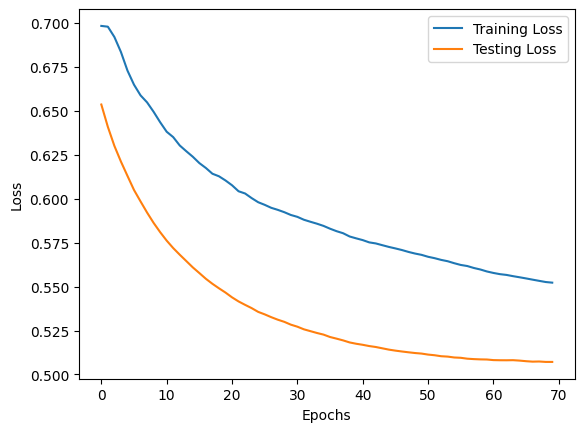

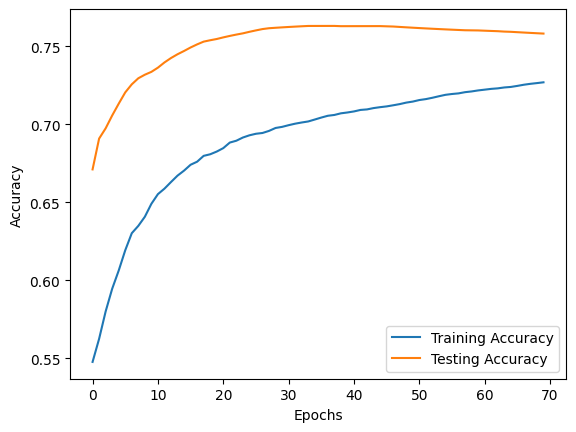

In [19]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 32
base_nn = NeuralNetwork(base_model,'sgd')
base_train = base_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
base_model.save_weights('/content/drive/MyDrive/ML_2/final_part_2_base_model_weights.h5')

Optimizer is SGD
The Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7813, Train Accuracy: 0.4572, Test Loss: 0.7048, Test Accuracy: 0.5263
Early Stopping Enabled
Epoch 2, Train Loss: 0.7510, Train Accuracy: 0.4934, Test Loss: 0.6644, Test Accuracy: 0.5888
Early Stopping Enabled
Epoch 3, Train Loss: 0.7312, Train Accuracy: 0.5252, Test Loss: 0.6339, Test Accuracy: 0.6184
Early Stopping Enabled
Epoch 4, Train Loss: 0.7164, Train Accuracy: 0.5452, Test Loss: 0.6130, Test Accuracy: 0.6349
Early Stopping Enabled
Epoch 5, Train Loss: 0.6968, Train Accuracy: 0.5661, Test Loss: 0.5965, Test Accuracy: 0.6447
Early Stopping Enabled
Epoch 6, Train Loss: 0.6821, Train Accuracy: 0.5828, Test Loss: 0.5831, Test Accuracy: 0.6513
Early Stopping Enabled
Epoch 7, Train Loss: 0.6735, Train Accuracy: 0.5923, Test Loss: 0.5739, Test Accuracy: 0.6560
Early Stopping Enabled
Epoch 8, Train Loss: 0.6616, Train Accuracy: 0.6042, Test Loss: 0.5639, Test Accuracy: 0.6612
Early Stopping Enabled
Epoch 9, 

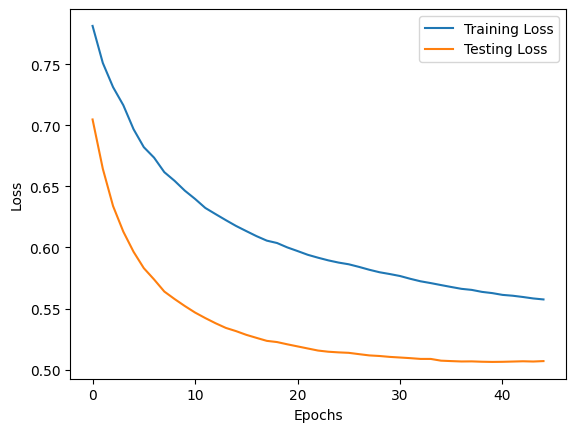

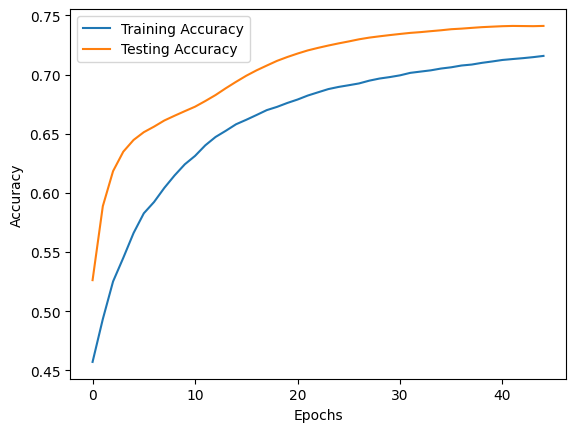

In [51]:
model_15 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer=initializers.Orthogonal(gain=1.0)),
    tf.keras.layers.Dropout(0.8),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 16
fifteen_nn = NeuralNetwork(model_15,'sgd')
fifteen_train = fifteen_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,early_stopping= True,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_15.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_15_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7727, Train Accuracy: 0.5510, Test Loss: 0.6358, Test Accuracy: 0.7237
Epoch 2, Train Loss: 0.7455, Train Accuracy: 0.5724, Test Loss: 0.5983, Test Accuracy: 0.7500
Epoch 3, Train Loss: 0.7260, Train Accuracy: 0.5773, Test Loss: 0.5738, Test Accuracy: 0.7632
Epoch 4, Train Loss: 0.7165, Train Accuracy: 0.5909, Test Loss: 0.5585, Test Accuracy: 0.7681
Epoch 5, Train Loss: 0.7009, Train Accuracy: 0.6020, Test Loss: 0.5502, Test Accuracy: 0.7711
Epoch 6, Train Loss: 0.6873, Train Accuracy: 0.6127, Test Loss: 0.5374, Test Accuracy: 0.7741
Epoch 7, Train Loss: 0.6839, Train Accuracy: 0.6177, Test Loss: 0.5326, Test Accuracy: 0.7763
Epoch 8, Train Loss: 0.6725, Train Accuracy: 0.6260, Test Loss: 0.5306, Test Accuracy: 0.7796
Epoch 9, Train Loss: 0.6640, Train Accuracy: 0.6321, Test Loss: 0.5298, Test Accuracy: 0.7814
Epoch 10, Train Loss: 0.6580, Train Accuracy: 0.6368, Test Loss: 0.5292, Test Accuracy: 0.7822
Epoc

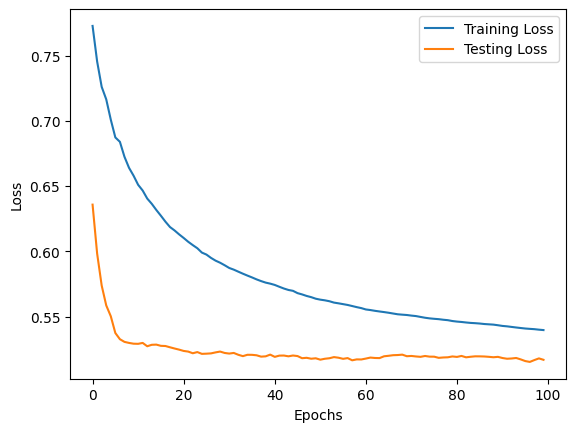

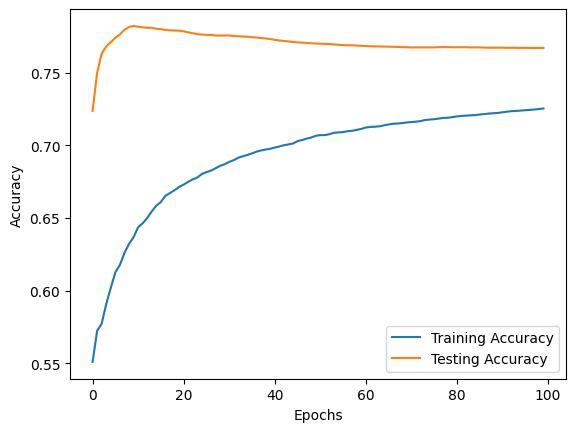

In [24]:
model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,),kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 16
sixteen_nn = NeuralNetwork(model_16,'sgd')
sixteen_train = sixteen_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_16.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_16_weights.h5')

Optimizer is SGD
THe Step Decay Flag Was set to  True
Epoch 1, Train Loss: 0.7331, Train Accuracy: 0.5905, Test Loss: 0.5554, Test Accuracy: 0.7171
Epoch 2, Train Loss: 0.6624, Train Accuracy: 0.6406, Test Loss: 0.5306, Test Accuracy: 0.7270
Epoch 3, Train Loss: 0.6267, Train Accuracy: 0.6639, Test Loss: 0.5249, Test Accuracy: 0.7303
Epoch 4, Train Loss: 0.6200, Train Accuracy: 0.6719, Test Loss: 0.5171, Test Accuracy: 0.7352
Epoch 5, Train Loss: 0.6051, Train Accuracy: 0.6822, Test Loss: 0.5169, Test Accuracy: 0.7355
Epoch 6, Train Loss: 0.5948, Train Accuracy: 0.6900, Test Loss: 0.5152, Test Accuracy: 0.7357
Epoch 7, Train Loss: 0.5875, Train Accuracy: 0.6971, Test Loss: 0.5147, Test Accuracy: 0.7359
Epoch 8, Train Loss: 0.5814, Train Accuracy: 0.6996, Test Loss: 0.5146, Test Accuracy: 0.7344
Epoch 9, Train Loss: 0.5786, Train Accuracy: 0.6999, Test Loss: 0.5145, Test Accuracy: 0.7332
Epoch 10, Train Loss: 0.5744, Train Accuracy: 0.7020, Test Loss: 0.5156, Test Accuracy: 0.7322
Epoch

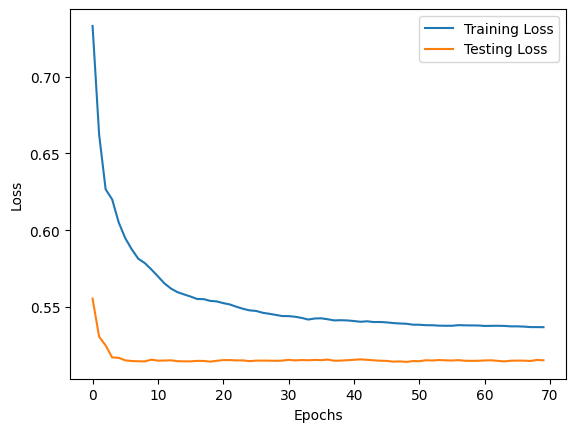

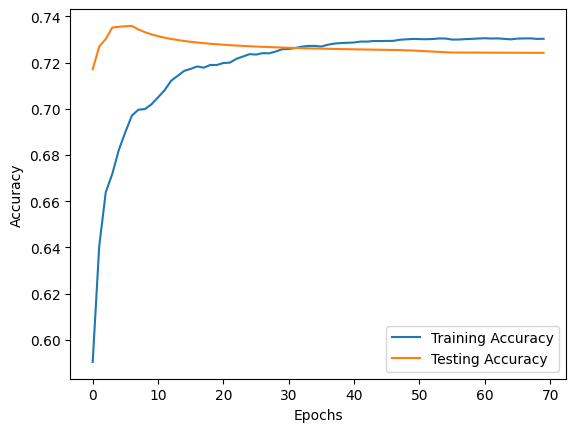

In [25]:
model_17 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
epochs =70
batch_size = 16
seventeen_nn = NeuralNetwork(model_17,'sgd')
seventeen_train = seventeen_nn.train(X_train,y_train,X_val,y_val,epochs,batch_size,step_decay_flag=True,trainingLossArr = [],trainingAccArr = [],testingLossArr = [],testingAccArr = [])
model_17.save_weights('/content/drive/MyDrive/ML_2/final_part_2_model_17_weights.h5')

Optimizer is SGD
<class 'pandas.core.frame.DataFrame'>
Fold 1/4
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.8304, Train Accuracy: 0.5246, Test Loss: 0.6714, Test Accuracy: 0.5526
Epoch 2, Train Loss: 0.8537, Train Accuracy: 0.5223, Test Loss: 0.6544, Test Accuracy: 0.5888
Epoch 3, Train Loss: 0.8438, Train Accuracy: 0.5104, Test Loss: 0.6454, Test Accuracy: 0.6140
Epoch 4, Train Loss: 0.8393, Train Accuracy: 0.5100, Test Loss: 0.6347, Test Accuracy: 0.6349
Epoch 5, Train Loss: 0.8370, Train Accuracy: 0.5138, Test Loss: 0.6283, Test Accuracy: 0.6539
Epoch 6, Train Loss: 0.8319, Train Accuracy: 0.5123, Test Loss: 0.6258, Test Accuracy: 0.6711
Epoch 7, Train Loss: 0.8211, Train Accuracy: 0.5163, Test Loss: 0.6233, Test Accuracy: 0.6842
Epoch 8, Train Loss: 0.8149, Train Accuracy: 0.5170, Test Loss: 0.6180, Test Accuracy: 0.6933
Epoch 9, Train Loss: 0.8145, Train Accuracy: 0.5193, Test Loss: 0.6149, Test Accuracy: 0.6966
Epoch 10, Train Loss: 0.8071, Train Accuracy: 0.5232

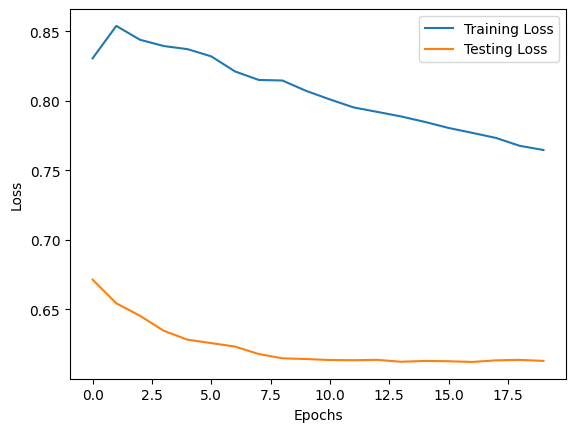

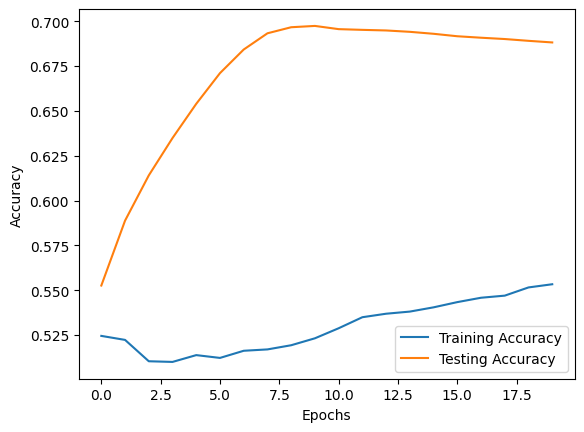

Fold 2/4
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7622, Train Accuracy: 0.5551, Test Loss: 0.6158, Test Accuracy: 0.6870
Epoch 2, Train Loss: 0.7593, Train Accuracy: 0.5561, Test Loss: 0.6170, Test Accuracy: 0.6860
Epoch 3, Train Loss: 0.7565, Train Accuracy: 0.5581, Test Loss: 0.6187, Test Accuracy: 0.6851
Epoch 4, Train Loss: 0.7552, Train Accuracy: 0.5593, Test Loss: 0.6210, Test Accuracy: 0.6845
Epoch 5, Train Loss: 0.7529, Train Accuracy: 0.5604, Test Loss: 0.6231, Test Accuracy: 0.6837
Epoch 6, Train Loss: 0.7509, Train Accuracy: 0.5617, Test Loss: 0.6247, Test Accuracy: 0.6835
Epoch 7, Train Loss: 0.7489, Train Accuracy: 0.5626, Test Loss: 0.6255, Test Accuracy: 0.6835
Epoch 8, Train Loss: 0.7465, Train Accuracy: 0.5643, Test Loss: 0.6276, Test Accuracy: 0.6835
Epoch 9, Train Loss: 0.7444, Train Accuracy: 0.5648, Test Loss: 0.6279, Test Accuracy: 0.6833
Epoch 10, Train Loss: 0.7433, Train Accuracy: 0.5650, Test Loss: 0.6288, Test Accuracy: 0.6831
Epoch 11, Tr

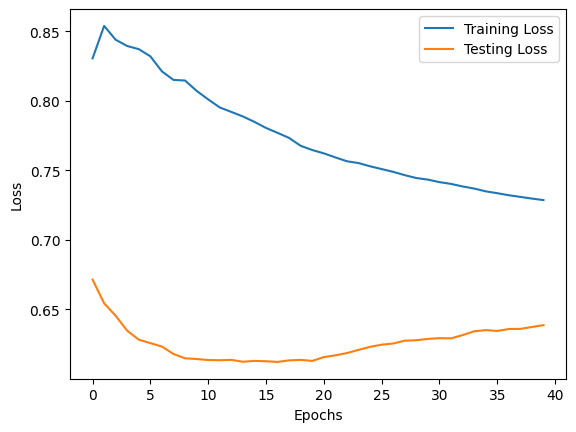

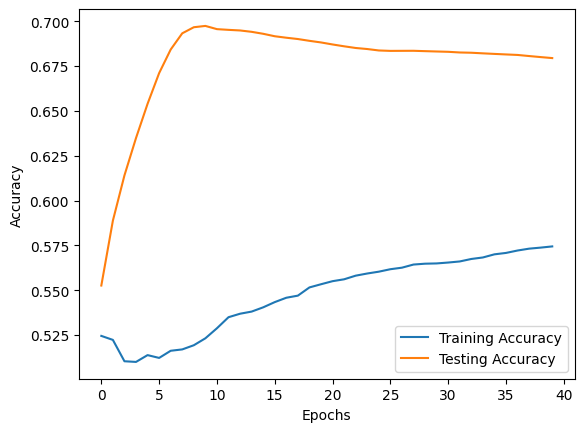

Fold 3/4
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7278, Train Accuracy: 0.5748, Test Loss: 0.6394, Test Accuracy: 0.6789
Epoch 2, Train Loss: 0.7268, Train Accuracy: 0.5756, Test Loss: 0.6389, Test Accuracy: 0.6784
Epoch 3, Train Loss: 0.7250, Train Accuracy: 0.5767, Test Loss: 0.6388, Test Accuracy: 0.6779
Epoch 4, Train Loss: 0.7233, Train Accuracy: 0.5780, Test Loss: 0.6398, Test Accuracy: 0.6775
Epoch 5, Train Loss: 0.7224, Train Accuracy: 0.5788, Test Loss: 0.6383, Test Accuracy: 0.6770
Epoch 6, Train Loss: 0.7212, Train Accuracy: 0.5800, Test Loss: 0.6375, Test Accuracy: 0.6766
Epoch 7, Train Loss: 0.7200, Train Accuracy: 0.5809, Test Loss: 0.6369, Test Accuracy: 0.6762
Epoch 8, Train Loss: 0.7190, Train Accuracy: 0.5818, Test Loss: 0.6373, Test Accuracy: 0.6758
Epoch 9, Train Loss: 0.7178, Train Accuracy: 0.5828, Test Loss: 0.6355, Test Accuracy: 0.6755
Epoch 10, Train Loss: 0.7167, Train Accuracy: 0.5837, Test Loss: 0.6356, Test Accuracy: 0.6751
Epoch 11, Tr

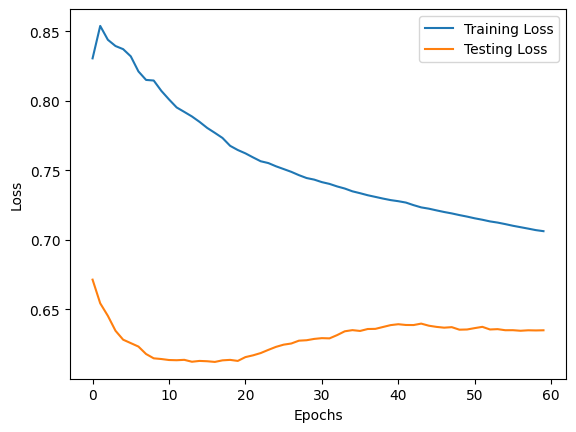

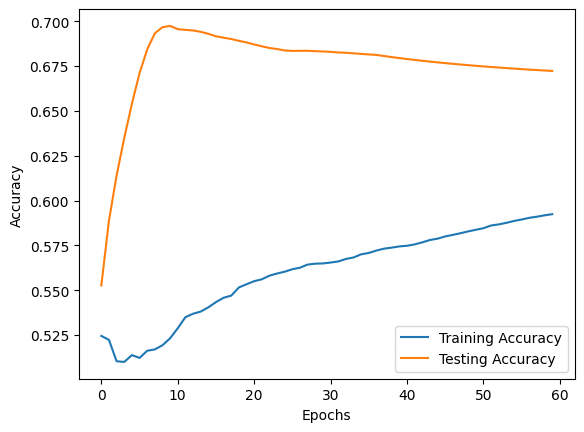

Fold 4/4
THe Step Decay Flag Was set to  False
Epoch 1, Train Loss: 0.7057, Train Accuracy: 0.5929, Test Loss: 0.6359, Test Accuracy: 0.6720
Epoch 2, Train Loss: 0.7049, Train Accuracy: 0.5934, Test Loss: 0.6376, Test Accuracy: 0.6718
Epoch 3, Train Loss: 0.7042, Train Accuracy: 0.5942, Test Loss: 0.6379, Test Accuracy: 0.6716
Epoch 4, Train Loss: 0.7036, Train Accuracy: 0.5946, Test Loss: 0.6366, Test Accuracy: 0.6714
Epoch 5, Train Loss: 0.7030, Train Accuracy: 0.5951, Test Loss: 0.6390, Test Accuracy: 0.6712
Epoch 6, Train Loss: 0.7024, Train Accuracy: 0.5956, Test Loss: 0.6397, Test Accuracy: 0.6710
Epoch 7, Train Loss: 0.7015, Train Accuracy: 0.5965, Test Loss: 0.6409, Test Accuracy: 0.6708
Epoch 8, Train Loss: 0.7008, Train Accuracy: 0.5971, Test Loss: 0.6421, Test Accuracy: 0.6706
Epoch 9, Train Loss: 0.7002, Train Accuracy: 0.5977, Test Loss: 0.6420, Test Accuracy: 0.6704
Epoch 10, Train Loss: 0.6996, Train Accuracy: 0.5981, Test Loss: 0.6431, Test Accuracy: 0.6702
Epoch 11, Tr

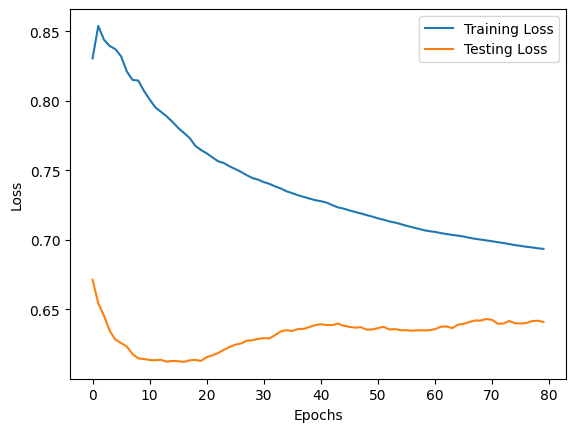

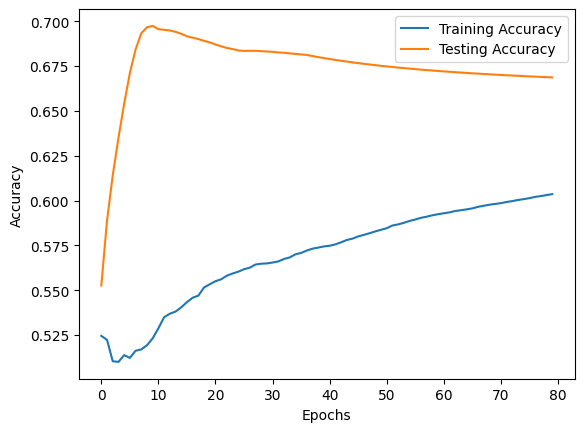

In [45]:
model_18 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

epochs =20
batch_size = 32
eighteen_nn = NeuralNetwork(model_18,'sgd')

num_batchs = 4
k_splitter = KFold(n_splits=num_batchs, shuffle=True)
fold_accuracy = []
a_18 = []
b_18 = []
c_18 = []
d_18 = []
print(type(X_train))
for batch, (train_indices, val_indices) in enumerate(k_splitter.split(X_train)):
    print(f'Fold {batch+1}/{num_batchs}')
    train_X = np.take(X_train,train_indices,axis = 0)
    train_y = np.take(y_train,train_indices,axis = 0)
    val_X = np.take(X_train,val_indices,axis = 0)
    val_y = np.take(y_train,val_indices,axis = 0)
    a_18,b_18,c_18,d_18 = eighteen_nn.train(train_X,train_y,val_X,val_y,epochs,batch_size,trainingLossArr=a_18,trainingAccArr=b_18,testingLossArr=c_18,testingAccArr = d_18)
model_18.save_weights('/content/drive/MyDrive/ML_2/final_part_1_model_18_weights.h5')

References 

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/Adamax


https://www.tensorflow.org/api_docs/python/tf/keras/optimizers


https://www.tensorflow.org/api_docs/python/tf/keras/activations



https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/


https://www.geeksforgeeks.org/matplotlib-pyplot-scatter-in-python/